In [1]:
# importing libraries

import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
import seaborn as sns; sns.set_style('whitegrid')
import datetime
import yfinance as yf
yf.pdr_override()

In [2]:
# defining a method to find cointegrated security pairs

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix=np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue <0.05 : # threshold for p-value
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [3]:
# Checking through a list of tech companies in the US Markets to see if there are any cointegrated pairs

start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2023, 1, 1)

tickers_tech = ['AAPL', 'AMD', 'AMZN', 'CSCO', 'EA', 'GOOG', 'HPQ', 'IBM', 'INTC', 'META', 'MSFT', 'NVDA', 'ORCL', 'TSM']
tickers_banking = ['BAC', 'C', 'GS', 'HSBC', 'JPM', 'MS', 'SCHW','UBS', 'WFC']

df1 = pdr.get_data_yahoo(tickers_tech, start, end)['Adj Close']
df2 = pdr.get_data_yahoo(tickers_banking, start, end)['Adj Close']

[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  9 of 9 completed


[('AMD', 'NVDA'), ('EA', 'MSFT'), ('EA', 'TSM'), ('IBM', 'INTC')]
[('SCHW', 'UBS')]


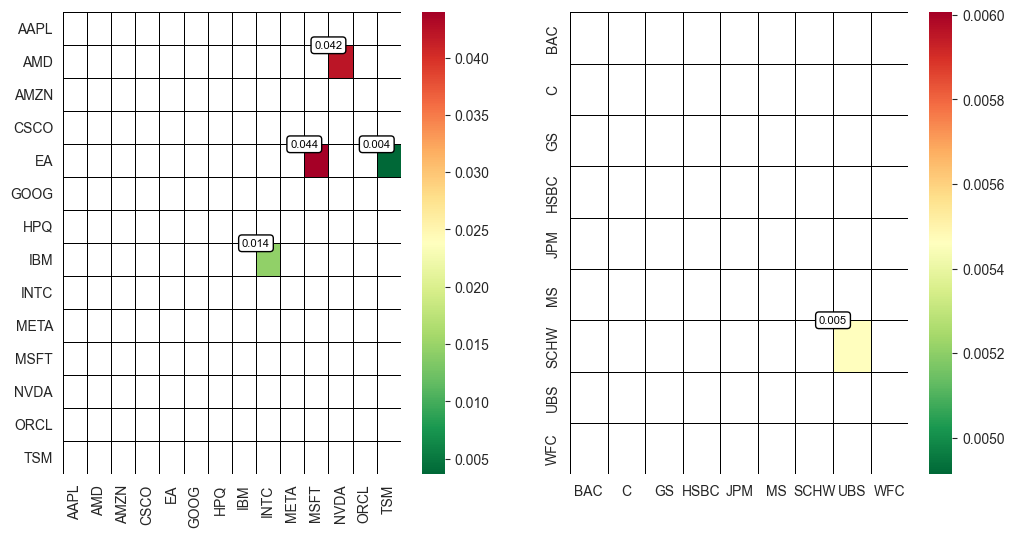

In [4]:
# Heatmap to show the p-values of the cointegration test between each pair of stocks
# NOTE: Low p-value means high cointegration!!

fig, ax = plt.subplots(1,2, figsize=(12, 6))

# tech stocks

scores_tech, pvalues_tech, pairs_tech = find_cointegrated_pairs(df1)
sns.heatmap(pvalues_tech, xticklabels=tickers_tech, yticklabels=tickers_tech, cmap='RdYlGn_r', linewidths = 0.5, linecolor = "black", mask = (pvalues_tech >= 0.05), ax=ax[0]) # showing only the pairs with p-value < 0.05
print(pairs_tech)
for i, j in zip(*np.triu_indices_from(pvalues_tech, k=1)):
    if pvalues_tech[i, j] < 0.05:
        ax[0].annotate("%.3f" % pvalues_tech[i, j], (j, i), size=8, ha='center', va='center', color='black', bbox=dict(boxstyle='round', fc='white', ec='black', lw=1))

# banking stocks
scores_banking, pvalues_banking, pairs_banking = find_cointegrated_pairs(df2)
sns.heatmap(pvalues_banking, xticklabels=tickers_banking, yticklabels=tickers_banking, cmap='RdYlGn_r', linewidths = 0.5, linecolor = 'black', mask = (pvalues_banking >= 0.05), ax=ax[1]) # showing only the pairs with p-value < 0.05
print(pairs_banking)
for i, j in zip(*np.triu_indices_from(pvalues_banking, k=1)):
    if pvalues_banking[i, j] < 0.05:
        ax[1].annotate("%.3f" % pvalues_banking[i, j], (j, i), size=8, ha='center', va='center', color='black', bbox=dict(boxstyle='round', fc='white', ec='black', lw=1))

In [5]:
# choosing a pair of tech stocks with the least p-value

S1_tech = df1['EA']
S2_tech = df1['TSM']
score_tech, pvalue_tech, _ = coint(S1_tech, S2_tech)
print("TECH STOCKS")
print("Stock 1: " + S1_tech.name + " and Stock 2: " + S2_tech.name + " have a cointegration score of " + str(score_tech) + " and a p-value of " + str(pvalue_tech))
print()

# choosing a pair of banking stocks with the least p-value

S1_banking = df2['SCHW']
S2_banking = df2['UBS']
score_banking, pvalue_banking, _ = coint(S1_banking, S2_banking)
print("BANKING STOCKS")
print("Stock 1: " + S1_banking.name + " and Stock 2: " + S2_banking.name + " have a cointegration score of " + str(score_banking) + " and a p-value of " + str(pvalue_banking))

TECH STOCKS
Stock 1: EA and Stock 2: TSM have a cointegration score of -4.200232976129219 and a p-value of 0.0036448645993643453

BANKING STOCKS
Stock 1: SCHW and Stock 2: UBS have a cointegration score of -4.082403588529887 and a p-value of 0.005459767198885355


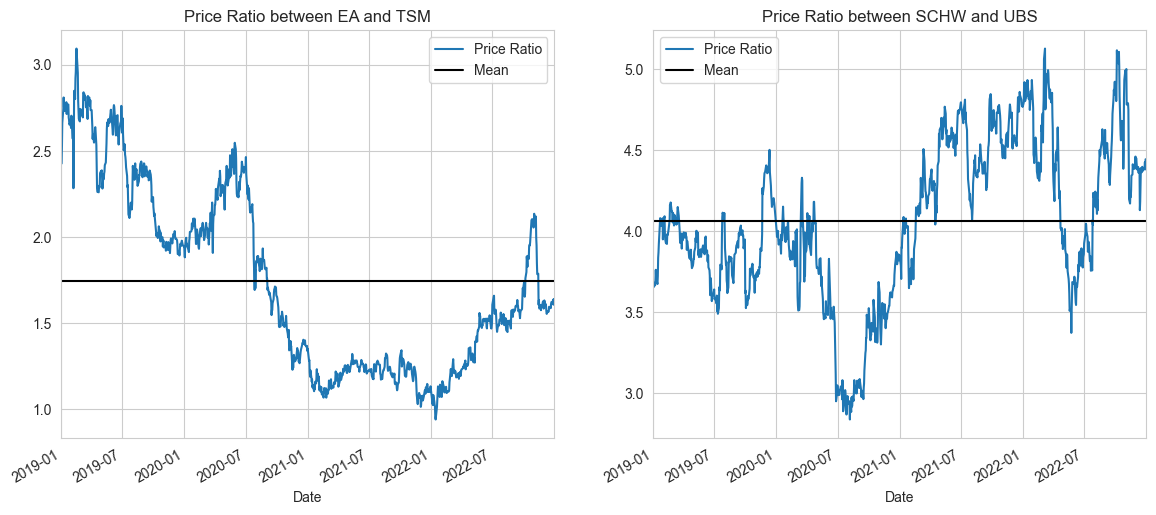

In [6]:
# Examining the ratio between the two tech stock prices and plotting it

ratio_tech = S1_tech/S2_tech
plt.subplot(1, 2, 1)
ratio_tech.plot(figsize=(14,6))
plt.axhline(ratio_tech.mean(), color='black')
plt.xlim(start, end)
plt.title("Price Ratio between " + S1_tech.name + " and " + S2_tech.name)
plt.legend(['Price Ratio', 'Mean']);

# Examining the ratio between the two banking stock prices and plotting it

ratio_banking = S1_banking/S2_banking
plt.subplot(1, 2, 2)
ratio_banking.plot(figsize=(14,6))
plt.axhline(ratio_banking.mean(), color='black')
plt.xlim(start, end)
plt.title("Price Ratio between " + S1_banking.name + " and " + S2_banking.name)
plt.legend(['Price Ratio', 'Mean']);

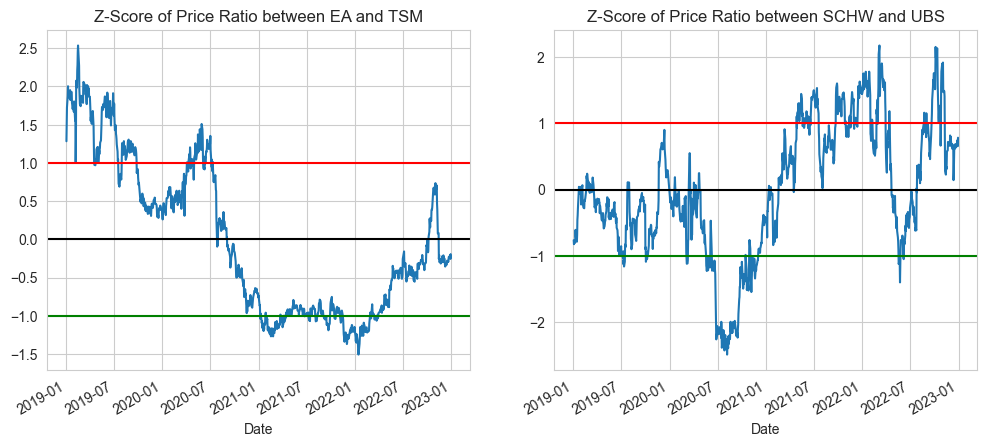

In [7]:
# Clearly from the above plot, the ratio is stationary and mean-reverting

# However, we need to standardize this ratio using z-scores
# z-score is the number of standard deviations from the mean a data point is, i.e, z = (x - mean)/std

def zscore(ratio):
    return (ratio - ratio.mean())/np.std(ratio)

plt.subplot(1, 2, 1)
zscore(ratio_tech).plot(figsize=(12,5))
plt.axhline(zscore(ratio_tech).mean(), color='black')
plt.axhline(1, color = 'r') # upper threshold
plt.axhline(-1, color='g') # lower threshold
plt.title("Z-Score of Price Ratio between " + S1_tech.name + " and " + S2_tech.name)

plt.subplot(1, 2, 2)
zscore(ratio_banking).plot(figsize=(12,5))
plt.axhline(zscore(ratio_banking).mean(), color='black')
plt.axhline(1, color = "red") # upper threshold
plt.axhline(-1, color='green') # lower threshold
plt.title("Z-Score of Price Ratio between " + S1_banking.name + " and " + S2_banking.name);

In [9]:
# We use the z-score to detemine trading signals

# Finding the total number of trading days in the dataset

ratios_tech = df1[S1_tech.name]/df1[S2_tech.name]
datasize_tech = len(ratios_tech)
print(datasize_tech)

ratios_banking = df2[S1_banking.name]/df2[S2_banking.name]
datasize_banking = len(ratios_banking)
print(datasize_banking)

1008
1008


In [10]:
# Splitting the dataset into training and testing sets (70/30)

train_tech = ratios_tech[:int(0.7*datasize_tech)]
test_tech = ratios_tech[int(0.7*datasize_tech):]

train_banking = ratios_banking[:int(0.7*datasize_banking)]
test_banking = ratios_banking[int(0.7*datasize_banking):]

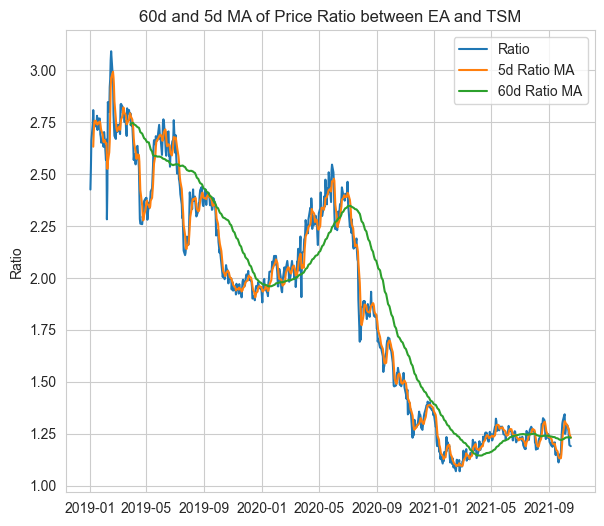

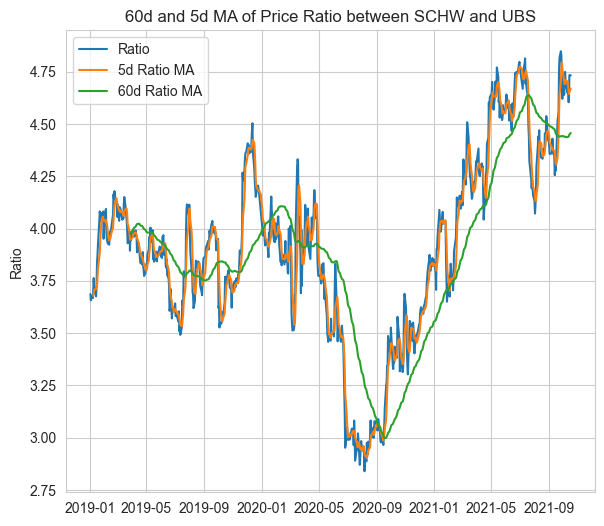

In [11]:
ratios_mavg5_tech = train_tech.rolling(window=5, center=False).mean()
ratios_mavg60_tech = train_tech.rolling(window=60, center=False).mean()
std_60_tech = train_tech.rolling(window=60, center=False).std()
zscore_60_5_tech = (ratios_mavg5_tech - ratios_mavg60_tech)/std_60_tech
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(train_tech.index, train_tech.values)
plt.plot(ratios_mavg5_tech.index, ratios_mavg5_tech.values)
plt.plot(ratios_mavg60_tech.index, ratios_mavg60_tech.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])
plt.ylabel('Ratio')
plt.title("60d and 5d MA of Price Ratio between " + S1_tech.name + " and " + S2_tech.name)
plt.show()

ratios_mavg5_banking = train_banking.rolling(window=5, center=False).mean()
ratios_mavg60_banking = train_banking.rolling(window=60, center=False).mean()
std_60_banking = train_banking.rolling(window=60, center=False).std()
zscore_60_5_banking = (ratios_mavg5_banking - ratios_mavg60_banking)/std_60_banking
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 2)
plt.plot(train_banking.index, train_banking.values)
plt.plot(ratios_mavg5_banking.index, ratios_mavg5_banking.values)
plt.plot(ratios_mavg60_banking.index, ratios_mavg60_banking.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])
plt.ylabel('Ratio')
plt.title("60d and 5d MA of Price Ratio between " + S1_banking.name + " and " + S2_banking.name)
plt.show()

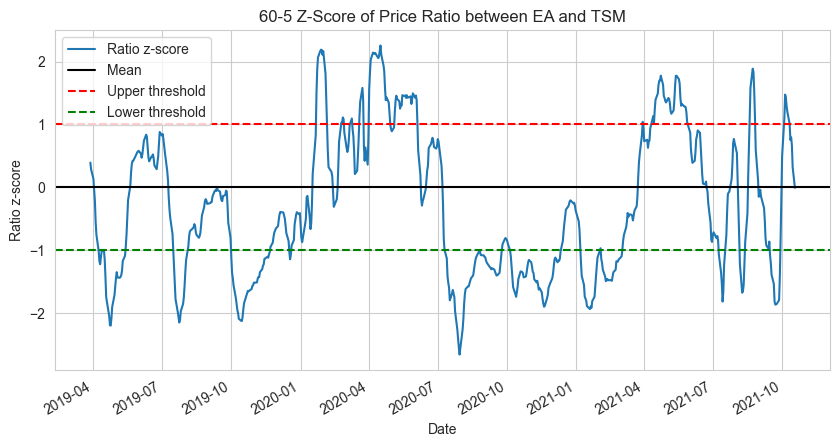

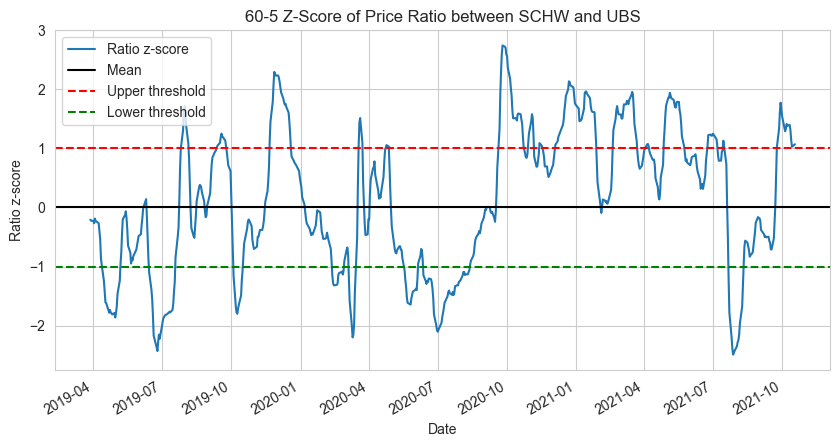

In [12]:
plt.figure(figsize=(10,5))
zscore_60_5_tech.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', 'Upper threshold', 'Lower threshold'])
plt.ylabel('Ratio z-score')
plt.title("60-5 Z-Score of Price Ratio between " + S1_tech.name + " and " + S2_tech.name)
plt.show()

plt.figure(figsize=(10,5))
zscore_60_5_banking.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', 'Upper threshold', 'Lower threshold'])
plt.ylabel('Ratio z-score')
plt.title("60-5 Z-Score of Price Ratio between " + S1_banking.name + " and " + S2_banking.name)
plt.show()

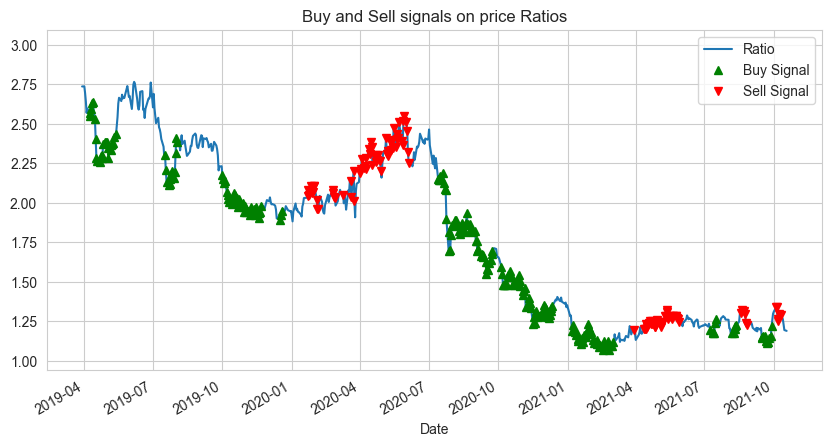

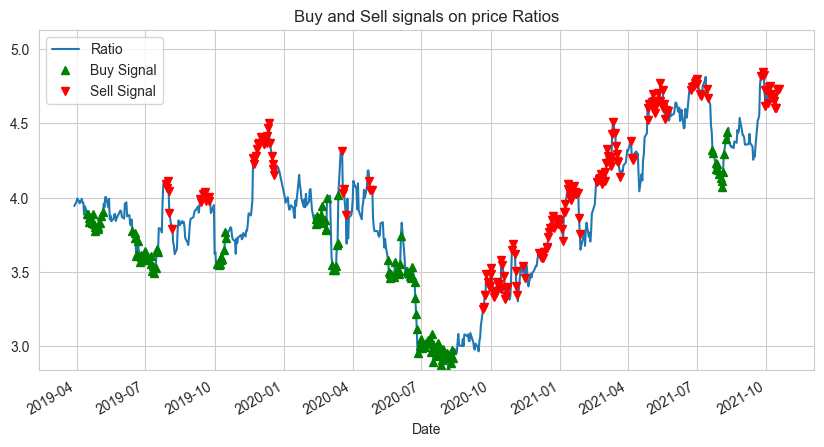

In [13]:
# Looking at the plot, it is clear that when the z-score moves 0.5 std beyond the mean, it tends to revert back to the mean
# We can use this to our advantage to create a trading strategy
# Buy(1) when the z-score is below -1, we expect the ratio to rise
# Sell(-1) when the z-score is above 1, we expect the ratio to fall

plt.figure(figsize=(10,5))
train_tech[60:].plot()
buy_tech = train_tech.copy()
sell_tech = train_tech.copy()
buy_tech[zscore_60_5_tech > -1] = 0
sell_tech[zscore_60_5_tech < 1] = 0
buy_tech[60:].plot(color='g', linestyle='None', marker='^')
sell_tech[60:].plot(color='r', linestyle='None', marker='v')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios_tech.min(), ratios_tech.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title("Buy and Sell signals on price Ratios")
plt.show()

plt.figure(figsize=(10,5))
train_banking[60:].plot()
buy_banking = train_banking.copy()
sell_banking = train_banking.copy()
buy_banking[zscore_60_5_banking > -1] = 0
sell_banking[zscore_60_5_banking < 1] = 0
buy_banking[60:].plot(color='g', linestyle='None', marker='^')
sell_banking[60:].plot(color='r', linestyle='None', marker='v')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios_banking.min(), ratios_banking.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title("Buy and Sell signals on price Ratios")
plt.show()

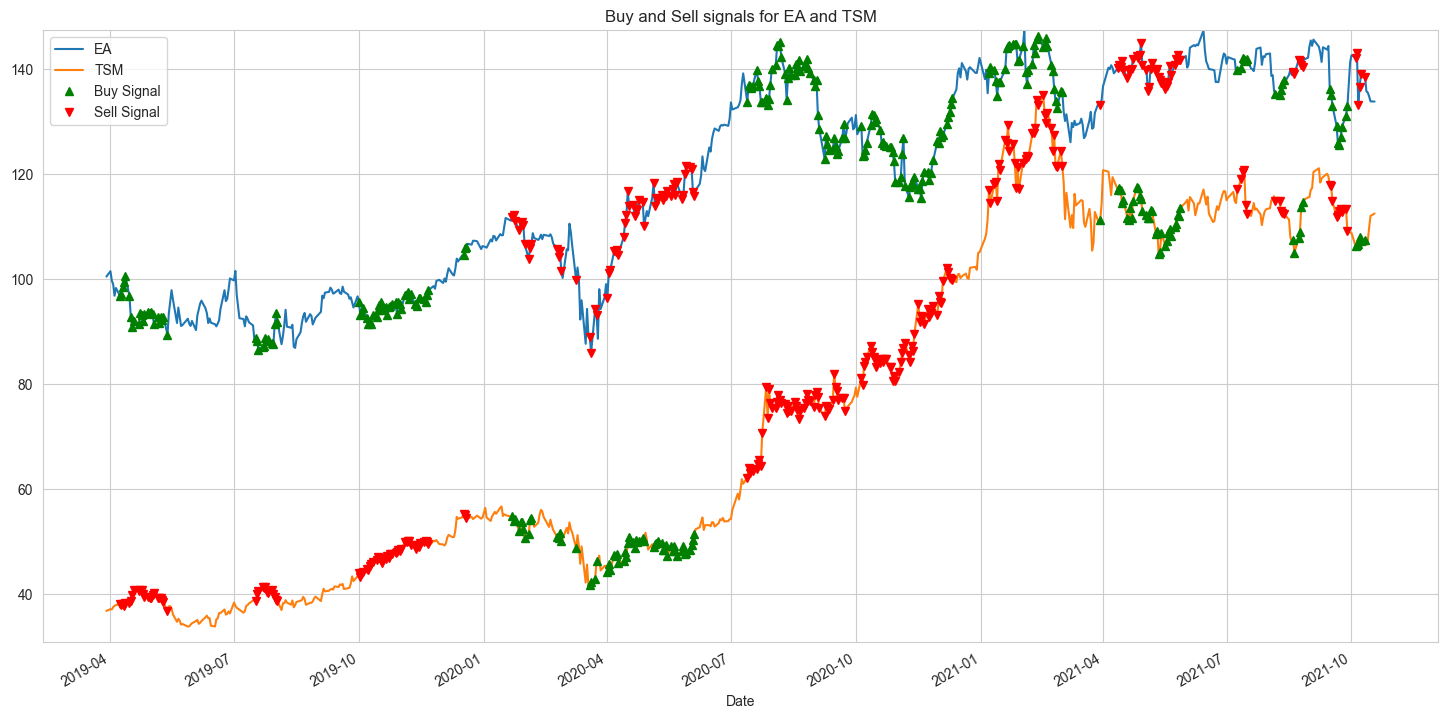

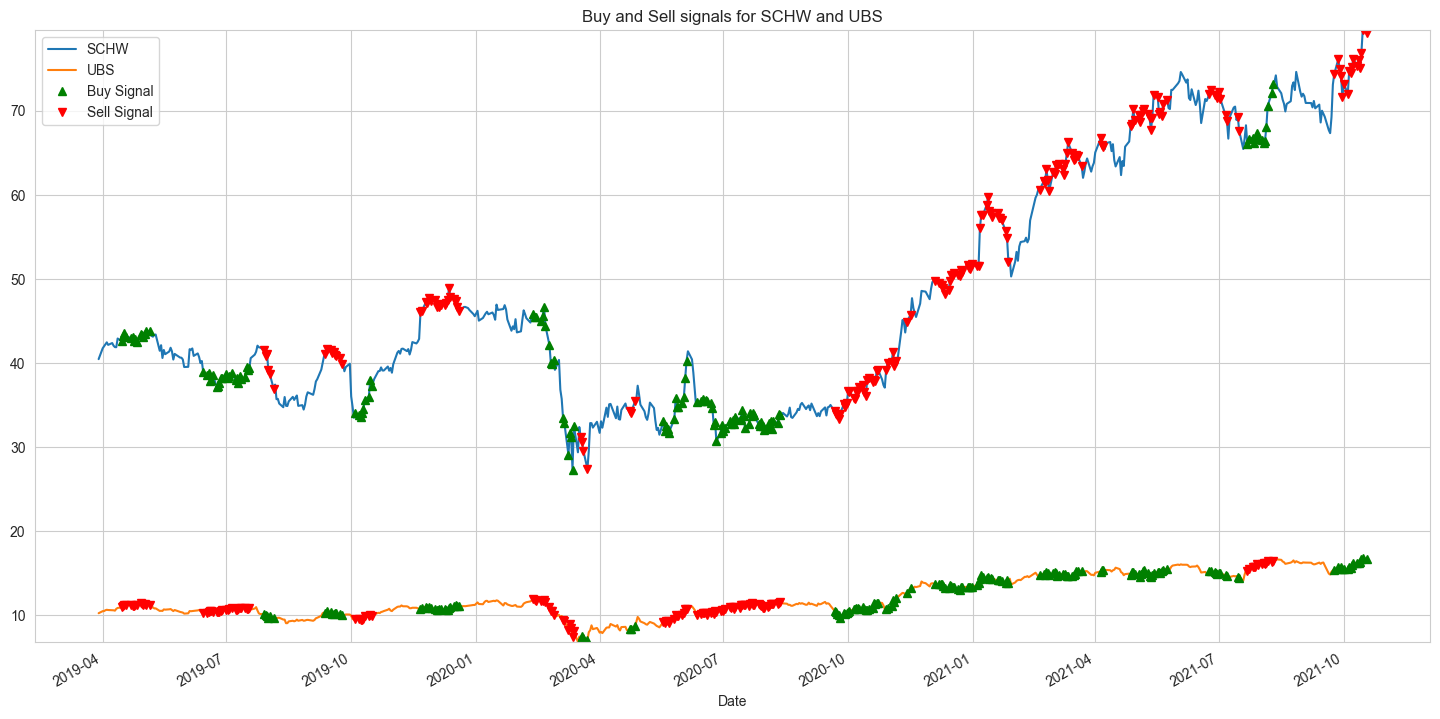

In [14]:
plt.figure(figsize=(18,9))
S1_tech = df1[S1_tech.name].iloc[:int(0.7*datasize_tech)]
S2_tech = df1[S2_tech.name].iloc[:int(0.7*datasize_tech)]

S1_tech[60:].plot()
S2_tech[60:].plot()
buyR_tech = 0*S1_tech.copy()
sellR_tech = 0*S1_tech.copy()

# When you buy the ratio, buy S1 and sell S2
buyR_tech[buy_tech!=0] = S1_tech[buy_tech!=0]
sellR_tech[buy_tech!=0] = S2_tech[buy_tech!=0]

# When you sell the ratio, sell S1 and buy S2
buyR_tech[sell_tech!=0] = S2_tech[sell_tech!=0]
sellR_tech[sell_tech!=0] = S1_tech[sell_tech!=0]

buyR_tech[60:].plot(color='g', linestyle='None', marker='^')
sellR_tech[60:].plot(color='r', linestyle='None', marker='v')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1_tech.min(), S2_tech.min()), max(S1_tech.max(), S2_tech.max())))
plt.legend([S1_tech.name, S2_tech.name, 'Buy Signal', 'Sell Signal'])
plt.title("Buy and Sell signals for " + S1_tech.name + " and " + S2_tech.name)
plt.show()

plt.figure(figsize=(18,9))
S1_banking = df2[S1_banking.name].iloc[:int(0.7*datasize_banking)]
S2_banking = df2[S2_banking.name].iloc[:int(0.7*datasize_banking)]

S1_banking[60:].plot()
S2_banking[60:].plot()
buyR_banking = 0*S1_banking.copy()
sellR_banking = 0*S1_banking.copy()

# When you buy the ratio, buy S1 and sell S2
buyR_banking[buy_banking!=0] = S1_banking[buy_banking!=0]
sellR_banking[buy_banking!=0] = S2_banking[buy_banking!=0]

# When you sell the ratio, sell S1 and buy S2
buyR_banking[sell_banking!=0] = S2_banking[sell_banking!=0]
sellR_banking[sell_banking!=0] = S1_banking[sell_banking!=0]

buyR_banking[60:].plot(color='g', linestyle='None', marker='^')
sellR_banking[60:].plot(color='r', linestyle='None', marker='v')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1_banking.min(), S2_banking.min()), max(S1_banking.max(), S2_banking.max())))
plt.legend([S1_banking.name, S2_banking.name, 'Buy Signal', 'Sell Signal'])
plt.title("Buy and Sell signals for " + S1_banking.name + " and " + S2_banking.name)
plt.show()

In [15]:
# Using the clear buy/sell signals, we can now create a trading strategy

def trade(S1, S2, window1, window2):

    # If window1 or window2 is 0, exit trade
    if (window1 == 0) or (window2 == 0):
        return 0

    # Compute moving average and rolling standard deviation
    ratios = S1/S2
    mavg1 = ratios.rolling(window=window1, center=False).mean()
    mavg2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (mavg1 - mavg2)/std

    # Simulate trading
    # Start with zero money and zero positions

    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0

    return money

In [33]:
trade(df1['EA'].iloc[int(0.7*datasize_tech):], df1['TSM'].iloc[int(0.7*datasize_tech):], 60, 10)

1118.3107737771516

In [40]:
trade(df2['SCHW'].iloc[int(0.7*datasize_banking):], df2['UBS'].iloc[int(0.7*datasize_banking):], 60, 5)

-281.8414440078532